In [2]:
# Load the data so we can use it
import pandas as pd
bitcoin = pd.read_csv('bitcoin.csv')

In [3]:
from tqdm import tnrange
# A little bit of feature engineering

bitcoin['Previous higher?'] = ""

for i in tnrange(len(bitcoin)-1,0,-1):
    if(i>0):
        bitcoin['Previous higher?'][i-1] = bitcoin['Low'][i].copy() > bitcoin['Low'][i-1].copy()
    bitcoin['Previous higher?'][2297] = False

c:\users\samue\.virtualenvs\bitcoin-prediction-7dql6spp\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\samue\.virtualenvs\bitcoin-prediction-7dql6spp\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [4]:
# A little more feature engineering
bitcoin['string_date'] = bitcoin['Date'].copy()

# bitcoin['avg_daily_price'] = (bitcoin['Open*']+bitcoin['High']+bitcoin['Low']+bitcoin['Close**'])/4

bitcoin['Date'] = pd.to_datetime(bitcoin['Date'])
bitcoin['Year'] = bitcoin['Date'].dt.year
bitcoin['Month'] = bitcoin['Date'].dt.month
bitcoin['Day'] = bitcoin['Date'].dt.day

In [5]:
# Change True/False to 1/0
new_columns = {True: 1, False:0}
bitcoin['Previous higher?'] = [new_columns[item] for item in bitcoin['Previous higher?']]

In [6]:
train = bitcoin[bitcoin.Year < 2018]
val = bitcoin[(bitcoin.Year >2015) & (bitcoin.Year < 2018)]
test = bitcoin[bitcoin.Year >= 2013]

In [7]:
# Get the X and y parts for train, val, and test
drop_columns = ['Date','Close**', 'Volume', 'Market Cap', 'High', 'Low', 'Previous higher?']
target = 'Close**'
X_train = train.drop(columns=drop_columns)
y_train = train[target]
X_val = val.drop(columns=drop_columns)
y_val = val[target]
X_test = test.drop(columns=drop_columns)
y_test = test[target]

This is a regression problem.

In [8]:
accuracy = bitcoin['Previous higher?'].value_counts(normalize=True)[0]
print('Accuracy is', accuracy)

Accuracy is 0.603568320278503


In [9]:
bitcoin.head()

,Date,Open*,High,Low,Close**,Volume,Market Cap,Previous higher?,string_date,Year,Month,Day
0,2019-08-12,11528.19,11528.19,11320.95,11382.62,1.364720e+10,2.034410e+11,0,8/12/2019,2019,8,12
1,2019-08-11,11349.74,11523.58,11248.29,11523.58,1.577437e+10,2.059420e+11,1,8/11/2019,2019,8,11
2,2019-08-10,11861.56,11915.66,11323.90,11354.02,1.812536e+10,2.028900e+11,1,8/10/2019,2019,8,10
3,2019-08-09,11953.47,11970.46,11709.75,11862.94,1.833999e+10,2.119610e+11,0,8/9/2019,2019,8,9
4,2019-08-08,11954.04,11979.42,11556.17,11966.41,1.948159e+10,2.137880e+11,0,8/8/2019,2019,8,8


In [10]:
import seaborn as sns
y = bitcoin['Close**']
sns.distplot(y);

In [11]:
import numpy as np
y_log = np.log1p(y)
bitcoin['log(Bitcoin Close)'] = y_log

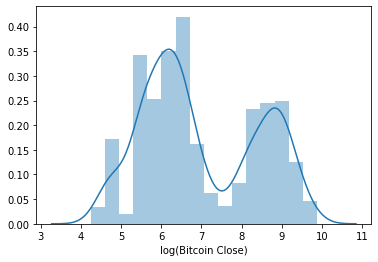

In [12]:
sns.distplot(bitcoin['log(Bitcoin Close)']);

c:\users\samue\.virtualenvs\bitcoin-prediction-7dql6spp\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


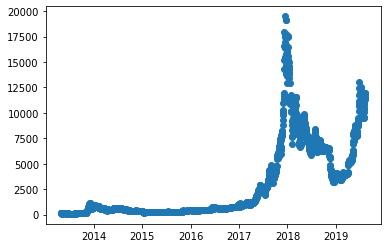

In [13]:
import matplotlib.pyplot as plt
import matplotlib

dates = matplotlib.dates.date2num(bitcoin['Date'])
plt.plot_date(dates, bitcoin['Close**']);

In [14]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

In [15]:
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

from joblib import dump
dump(pipeline, 'pipeline.joblib')

y_pred = pipeline.predict(X_test)
X_test['pred_price'] = y_pred

Validation Accuracy 0.9991087431123147


In [54]:
# Ploting all the predictions
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(
                x=bitcoin.Date,
                y=bitcoin['Close**'],
                name='Closing Price',
                line_color = 'green',
                opacity=0.8)
             )

fig.add_trace(go.Scatter(
                x=bitcoin.Date,
                y=X_test['pred_price'],
                name='Predicted close',
                line_color = 'red',
                opacity=0.8)
             )

fig.update_layout(xaxis_range=['2013-04-28','2019-08-12'],
                 title_text='Bitcoin Historical Data')

fig.show();

In [17]:
# Building a function to test prediction
def predict_price(Year, Month, Day):
    row = X_test[(X_test.Year==Year)&(X_test.Month==Month)&(X_test.Day==Day)]
    return row

In [18]:
# Testing the function
predict_price(2018, 6, 8)

,Open*,string_date,Year,Month,Day,pred_price
430,7685.14,6/8/2018,2018,6,8,11766.342


In [55]:
# Make a graph for the historical data using plotly
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(
                x=bitcoin.Date,
                y=bitcoin['High'],
                name='BTC High',
                line_color = 'green',
                opacity=0.8)
             )

fig.add_trace(go.Scatter(
                x=bitcoin.Date,
                y=bitcoin['Low'],
                name='BTC Low',
                line_color = 'red',
                opacity=0.8)
             )

fig.update_layout(xaxis_range=['2013-04-28','2019-08-12'],
                 title_text='Bitcoin Historical High and Low Data')

fig.show();

In [69]:
new_pipe = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestRegressor(random_state=42, n_jobs=-1)
)

new_pipe.fit(X_train, y_train);

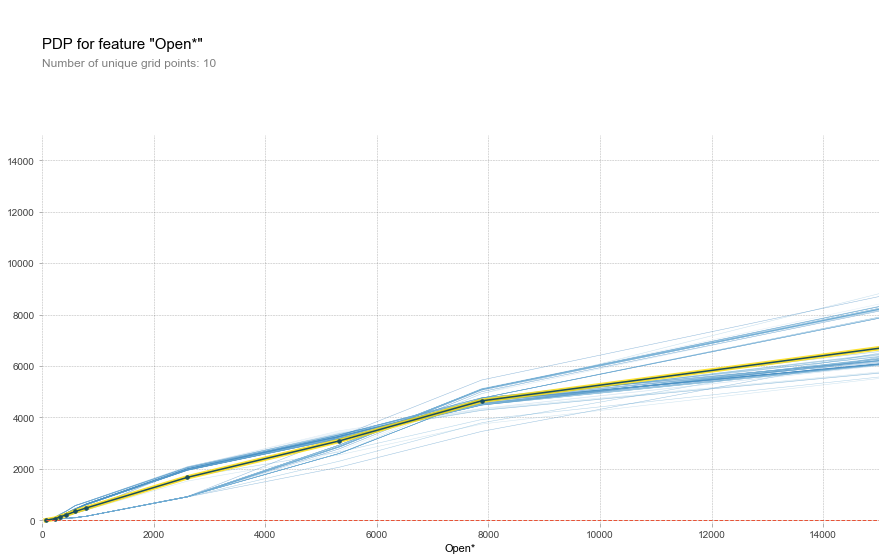

In [74]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Open*'

isolated = pdp_isolate(
    model=new_pipe,
    dataset=bitcoin,
    model_features=X_val.columns,
    feature=feature,
   num_grid_points=10
)

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100)
plt.xlim(0,15000);
plt.ylim(-100,15000);

In [63]:
bitcoin.columns

Index(['Date', 'Open*', 'High', 'Low', 'Close**', 'Volume', 'Market Cap',
       'Previous higher?', 'string_date', 'Year', 'Month', 'Day',
       'log(Bitcoin Close)'],
      dtype='object')